<a href="https://colab.research.google.com/github/JoseADios/SemanticSearchPython/blob/main/SemanticSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final: Sistema de Búsqueda Semántica para Artículos Científicos
## Inteligencia Artificial
## Profesor Lizandro Ramírez

In [1]:
# permisos para drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Intalacion de librerias

In [ ]:
!!pip install kaggle -q -U

['\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/82.7 kB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b82.7/82.7 kB\x1b \x1b2.2 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25h  Preparing metadata (setup.py) ... \x1b[?25l\x1b[?25hdone',
 '  Building wheel for kaggle (setup.py) ... \x1b[?25l\x1b[?25hdone']

In [ ]:
!pip install gensim spacy matplotlib transformers seaborn scikit-learn -q -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 45.4 MB/s eta 0:00:00


# Paso 1: Recoleccion de datos




### API KEY de Kaggle

In [ ]:
from google.colab import userdata
userdata.get('KAGGLE_API_KEY')

In [ ]:
!mkdir ~/.kaggle
!echo userdata.get('KAGGLE_API_KEY') > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d Cornell-University/arxiv
!echo "Y" | unzip arxiv.zip

## Conversion en CSV

In [ ]:
import pandas as pd

chunk_size = 10000  # Número de líneas por fragmento

df_list = []

# Leer el archivo en fragmentos
for chunk in pd.read_json('arxiv-metadata-oai-snapshot.json', lines=True, chunksize=chunk_size):
    df_list.append(chunk)

# Combinar todos los fragmentos
df = pd.concat(df_list, ignore_index=True)

In [ ]:
# Guardar el DataFrame combinado en un archivo CSV para futuras cargas más rápidas
df.to_csv('arxiv_metadata.csv', index=False)

### Guardar archivo en drive

In [ ]:
# crear carpeta ArxivDataset en drive
!mkdir /content/drive/MyDrive/ArxivDataset

# guardar el csv en drive
!cp arxiv_metadata.csv /content/drive/MyDrive/ArxivDataset/arxiv_metadata.csv

# Paso 2: Preprocesamiento de Datos

## Lectura del CSV, solo columnas necesarias

In [ ]:
import pandas as pd

# tamaño de la muestra
nrows = 2000

# obtener el csv solo con las columnas necesarias
df = pd.read_csv('/content/drive/MyDrive/ArxivDataset/arxiv_metadata.csv', nrows=nrows)[['id', 'title', 'abstract', 'authors']]

In [ ]:
# guardar df
df.to_csv('arxiv_metadata.csv', index=False)

In [ ]:
df.head()

,id,title,abstract,authors
0,704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-..."
1,704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",Ileana Streinu and Louis Theran
2,704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,Hongjun Pan
3,704.0004,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,David Callan
4,704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,Wael Abu-Shammala and Alberto Torchinsky


## 2.2 Preprocesamiento del texto


## Concatenar columnas

In [ ]:
import pandas as pd
import re

# Función para concatenar texto
def concatenate_text(row):
    return row['abstract'] + " \n " + row['authors']

# Tamaño del fragmento
chunk_size = 10000

# crear archivo concatenated_data.csv
with open('concatenated_data.csv', 'w') as f:
    f.write('id,title,text\n')

# Leer el archivo en fragmentos
for chunk in pd.read_csv('arxiv_metadata.csv', chunksize=chunk_size):
    chunk['text'] = chunk.apply(concatenate_text, axis=1)
    chunk = chunk[['id','title','text']]
    chunk.to_csv('concatenated_data.csv', mode='a', header=False, index=False)

## Limpieza y normalizacion

In [ ]:
import re

# Preprocesamiento: limpieza y normalización
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Elimina caracteres especiales
    return text

chunk_size = 10000

# crear archivo preprocessed_data.csv
with open('preprocessed_data.csv', 'w') as f:
    f.write('id,title,text\n')


for chunk in pd.read_csv('concatenated_data.csv', chunksize=chunk_size):
    chunk['text'] = chunk['text'].apply(preprocess_text)
    chunk.to_csv('preprocessed_data.csv', mode='a', header=False, index=False)

In [ ]:
df = pd.read_csv('preprocessed_data.csv')

df.head()

,id,title,text
0,704.0001,Calculation of prompt diphoton production cros...,a fully differential calculation in perturba...
1,704.0002,Sparsity-certifying Graph Decompositions,we describe a new algorithm the kellpebble g...
2,704.0003,The evolution of the Earth-Moon system based o...,the evolution of earthmoon system is describ...
3,704.0004,A determinant of Stirling cycle numbers counts...,we show that a determinant of stirling cycle...
4,704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,in this paper we show how to compute the lam...


## Guardar archivo en drive

In [ ]:
# actualizar el csv en drive
!cp preprocessed_data.csv /content/drive/MyDrive/ArxivDataset/preprocessed_data.csv

## 2.3 Tokenizar los artículos

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ArxivDataset/preprocessed_data.csv')

df.to_csv('preprocessed_data_sample.csv', index=False)

In [7]:
from transformers import AutoTokenizer, AutoModel
import torch

# Cargar el modelo y el tokenizador
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# Función para generar embeddings
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

## 2.4 Generar embbedings del texto

In [ ]:
# Generar embeddings para los artículos
df['embeddings'] = df['text'].apply(lambda x: get_embeddings(x).tolist())

In [ ]:
df.head()

,id,title,text,embeddings
0,704.0001,Calculation of prompt diphoton production cros...,a fully differential calculation in perturba...,"[-0.2910017669200897, -0.02164323441684246, -0..."
1,704.0002,Sparsity-certifying Graph Decompositions,we describe a new algorithm the kellpebble g...,"[-0.010978881269693375, 0.08786933869123459, 0..."
2,704.0003,The evolution of the Earth-Moon system based o...,the evolution of earthmoon system is describ...,"[-0.045425329357385635, -0.04259425774216652, ..."
3,704.0004,A determinant of Stirling cycle numbers counts...,we show that a determinant of stirling cycle...,"[-0.20050902664661407, -0.08039967715740204, -..."
4,704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,in this paper we show how to compute the lam...,"[0.01166077796369791, -0.08669306337833405, -0..."


In [5]:
# Guardar los embeddings para usarlos en búsquedas
df.to_pickle('arxiv_embeddings.pkl')

In [6]:
# Cargar los embeddings
df = pd.read_pickle('arxiv_embeddings.pkl')

## Guardar archivo en drive

In [ ]:
# guardar los embbedings en drive
!cp arxiv_embeddings.pkl /content/drive/MyDrive/ArxivDataset/arxiv_embeddings.pkl

In [2]:
import pandas as pd

# cargar el pkl en df
df = pd.read_pickle('/content/drive/MyDrive/ArxivDataset/arxiv_embeddings.pkl')

# 3 Busqueda

## Funcion de busqueda y similitud

In [8]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Cargar los embeddings
df = pd.read_pickle('arxiv_embeddings.pkl')

# Función de búsqueda y similitud
def search(query, df, top_k=5):
    query_embedding = get_embeddings(query)  # Obtener el embedding de la consulta
    similarities = cosine_similarity([query_embedding], list(df['embeddings']))[0]
    df['similarity'] = similarities  # similitud por coseno
    df['arxiv_url'] = 'https://arxiv.org/abs/0' + df['id'].astype(str)
    results = df.sort_values(by='similarity', ascending=False).head(top_k)
    return results


In [9]:
# Llamado a la funcion

results = search('quantum in artificial intelligence', df)
results

,id,title,text,embeddings,similarity,arxiv_url
1262,704.1263,The Measurement Calculus,measurementbased quantum computation has eme...,"[-0.21474485099315643, -0.04857734590768814, -...",0.559973,https://arxiv.org/abs/0704.1263
50,704.0051,Visualizing Teleportation,a novel way of picturing the processing of q...,"[-0.008586074225604534, 0.01673203893005848, -...",0.546151,https://arxiv.org/abs/0704.0051
201,704.0202,Towards Minimal Resources of Measurement-based...,we improve the upper bound on the minimal re...,"[-0.16044732928276062, 0.07335766404867172, -0...",0.546037,https://arxiv.org/abs/0704.0202
1961,704.1962,A simple test of quantumness for a single system,we propose a simple test of quantumness whic...,"[-0.09770772606134415, -0.040186479687690735, ...",0.534008,https://arxiv.org/abs/0704.1962
41,704.0042,"General System theory, Like-Quantum Semantics ...",it is outlined the possibility to extend the...,"[-0.04124566167593002, 0.00558986933901906, -0...",0.525622,https://arxiv.org/abs/0704.0042


## Busqueda con FAISS

### Instalar libreria

In [10]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 53.5 MB/s eta 0:00:00


### Funcion de busqueda FAISS

In [11]:
import faiss
import numpy as np

# Cargar los embeddings (si no están cargados)
if 'embeddings' not in df.columns:
    df = pd.read_pickle('arxiv_embeddings.pkl')

def busqueda_faiss(consulta, df, top_k=5):

    # Asegurarse de que los embeddings son arrays de NumPy
    if not isinstance(df['embeddings'].iloc[0], np.ndarray):
        df['embeddings'] = df['embeddings'].apply(np.array)

    # Crear el índice FAISS
    index = faiss.IndexFlatIP(df['embeddings'].iloc[0].shape[0])
    index.add(np.stack(df['embeddings']))

    # Obtener el embedding de la consulta
    consulta_embedding = get_embeddings(consulta)

    # Realizar la búsqueda
    distances, indices = index.search(np.array([consulta_embedding]), k=top_k)

    # Obtener los resultados
    resultados = df.iloc[indices[0]]
    resultados['distancia_faiss'] = distances[0]
    resultados = resultados.sort_values('distancia_faiss', ascending=True)

    return resultados

### Mostrar resultados de la busqueda

In [12]:
resultados = busqueda_faiss("quantum in artificial intelligence", df)
resultados

<ipython-input-11-ece3f5fe683b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultados['distancia_faiss'] = distances[0]


,id,title,text,embeddings,similarity,arxiv_url,distancia_faiss
608,704.0609,The effectiveness of quantum operations for ea...,a quantum protocol is described which enable...,"[-0.1752985566854477, -0.021981874480843544, -...",0.441271,https://arxiv.org/abs/0704.0609,9.598020
1279,704.1280,Controllable Quantum Switchboard,all quantum information processes inevitably...,"[-0.2338118851184845, -0.12500959634780884, -0...",0.477436,https://arxiv.org/abs/0704.128,10.211641
50,704.0051,Visualizing Teleportation,a novel way of picturing the processing of q...,"[-0.008586074225604534, 0.01673203893005848, -...",0.546151,https://arxiv.org/abs/0704.0051,10.703926
201,704.0202,Towards Minimal Resources of Measurement-based...,we improve the upper bound on the minimal re...,"[-0.16044732928276062, 0.07335766404867172, -0...",0.546037,https://arxiv.org/abs/0704.0202,11.380535
1308,704.1309,Quantum State Transfer with Spin Chains,the thesis covers various aspects of quantum...,"[-0.46770429611206055, -0.05286695808172226, -...",0.439296,https://arxiv.org/abs/0704.1309,15.629220


# Interfaz grafica para buscar resultados

In [13]:
# prompt: Agrega la opcion de elegir entre la funcion de busqueda normal y la busqueda con faiss

import ipywidgets as widgets
from IPython.display import display

# Cargar los embeddings (si no están cargados)
if 'embeddings' not in df.columns:
    df = pd.read_pickle('arxiv_embeddings.pkl')

# Función de búsqueda y similitud (copiada del código anterior)
def search(query, df, top_k=5):
    query_embedding = get_embeddings(query)  # Obtener el embedding de la consulta
    similarities = cosine_similarity([query_embedding], list(df['embeddings']))[0]
    df['similarity'] = similarities  # similitud por coseno
    df['arxiv_url'] = 'https://arxiv.org/abs/0' + df['id'].astype(str)
    results = df.sort_values(by='similarity', ascending=False).head(top_k)
    return results

# Función de búsqueda FAISS (copiada del código anterior)
def busqueda_faiss(consulta, df, top_k=5):
    # Asegurarse de que los embeddings son arrays de NumPy
    if not isinstance(df['embeddings'].iloc[0], np.ndarray):
        df['embeddings'] = df['embeddings'].apply(np.array)

    # Crear el índice FAISS
    index = faiss.IndexFlatIP(df['embeddings'].iloc[0].shape[0])
    index.add(np.stack(df['embeddings']))

    # Obtener el embedding de la consulta
    consulta_embedding = get_embeddings(consulta)

    # Realizar la búsqueda
    distances, indices = index.search(np.array([consulta_embedding]), k=top_k)

    # Obtener los resultados
    resultados = df.iloc[indices[0]]
    resultados['distancia_faiss'] = distances[0]
    resultados = resultados.sort_values('distancia_faiss', ascending=True)

    return resultados

# Widget para la entrada de texto
text_input = widgets.Text(
    value='',
    placeholder='Ingrese su consulta',
    description='Consulta:',
    disabled=False
)

# Widget para seleccionar el método de búsqueda
dropdown = widgets.Dropdown(
    options=['Cosine Similarity', 'FAISS'],
    value='Cosine Similarity',
    description='Método:',
    disabled=False,
)

# Widget para el botón de búsqueda
button = widgets.Button(
    description='Buscar',
    disabled=False,
    button_style='info',
    tooltip='Click para buscar',
    icon='search'
)

# Función para manejar el evento de clic en el botón
def on_button_clicked(b):
    query = text_input.value
    if dropdown.value == 'Cosine Similarity':
        results = search(query, df)
    else:
        results = busqueda_faiss(query, df)
    display(results)

# Asignar la función al evento de clic del botón
button.on_click(on_button_clicked)

# Mostrar los widgets
display(text_input, dropdown, button)


Text(value='', description='Consulta:', placeholder='Ingrese su consulta')

Dropdown(description='Método:', options=('Cosine Similarity', 'FAISS'), value='Cosine Similarity')

Button(button_style='info', description='Buscar', icon='search', style=ButtonStyle(), tooltip='Click para busc…

,id,title,text,embeddings,similarity,arxiv_url
1664,704.1665,Approach to Physical Reality: a note on Poinca...,we argue about a possible scenario of physic...,"[-0.13628756999969482, -0.027611546218395233, ...",0.127467,https://arxiv.org/abs/0704.1665
589,704.0590,A Low Complexity Algorithm and Architecture fo...,we present an algorithm for systematic encod...,"[-0.2928357720375061, 0.12369631975889206, -0....",0.122909,https://arxiv.org/abs/0704.059
1352,704.1353,Supporting Knowledge and Expertise Finding wit...,this paper reports on work aimed at supporti...,"[0.02174251899123192, 0.10020758956670761, -0....",0.118115,https://arxiv.org/abs/0704.1353
1146,704.1147,"Information, complexity, brains and reality (K...",i discuss several aspects of information the...,"[0.08547436445951462, -0.1643574982881546, -0....",0.115193,https://arxiv.org/abs/0704.1147
1615,704.1616,"Reply to Comment on ""Chiral suppression of sca...",reply to the comment of chao he and ma\n \n ...,"[-0.08808820694684982, 0.20518246293067932, 0....",0.114115,https://arxiv.org/abs/0704.1616


<ipython-input-13-580283f40585>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultados['distancia_faiss'] = distances[0]


,id,title,text,embeddings,similarity,arxiv_url,distancia_faiss
589,704.0590,A Low Complexity Algorithm and Architecture fo...,we present an algorithm for systematic encod...,"[-0.2928357720375061, 0.12369631975889206, -0....",0.122909,https://arxiv.org/abs/0704.059,2.128460
107,704.0108,Reducing SAT to 2-SAT,description of a polynomial time reduction o...,"[-0.28280162811279297, 0.3424893319606781, -0....",0.054035,https://arxiv.org/abs/0704.0108,2.160982
373,704.0374,Gravity-induced electric polarization of matte...,this paper has been withdrawn due to copyrig...,"[-0.9129697680473328, 0.36430615186691284, -0....",0.078796,https://arxiv.org/abs/0704.0374,2.163309
1352,704.1353,Supporting Knowledge and Expertise Finding wit...,this paper reports on work aimed at supporti...,"[0.02174251899123192, 0.10020758956670761, -0....",0.118115,https://arxiv.org/abs/0704.1353,2.259629
1615,704.1616,"Reply to Comment on ""Chiral suppression of sca...",reply to the comment of chao he and ma\n \n ...,"[-0.08808820694684982, 0.20518246293067932, 0....",0.114115,https://arxiv.org/abs/0704.1616,3.033030


# 4 Visualización de Resultados con PCA

## Importacion de bibliotecas

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Cargar el archivo .pkl
df = pd.read_pickle('arxiv_embeddings.pkl')

# Asegurarse de que los embeddings son arrays de una dimensión
df['embeddings'] = df['embeddings'].apply(np.array)


## Aplicar PCA

In [ ]:
# Extraer los embeddings
embeddings = np.array(df['embeddings'].tolist())

# Aplicar PCA
pca = PCA(n_components=2)  # Para 2D
embeddings_pca = pca.fit_transform(embeddings)

# Agregar los resultados de PCA al DataFrame
df['pca1'] = embeddings_pca[:, 0]
df['pca2'] = embeddings_pca[:, 1]


## Mostrar resultados

In [ ]:
import matplotlib.pyplot as plt

def visualizar_resultados_2d(resultados, columna_x, columna_y):
  """
  Visualiza resultados en un gráfico de dispersión 2D.

  Args:
    resultados: DataFrame con los resultados.
    columna_x: Nombre de la columna para el eje x.
    columna_y: Nombre de la columna para el eje y.
  """
  plt.figure(figsize=(10, 7))
  plt.scatter(resultados[columna_x], resultados[columna_y], alpha=0.5)
  plt.title('Gráfico de Dispersión de Resultados')
  plt.xlabel(columna_x)
  plt.ylabel(columna_y)
  plt.show()

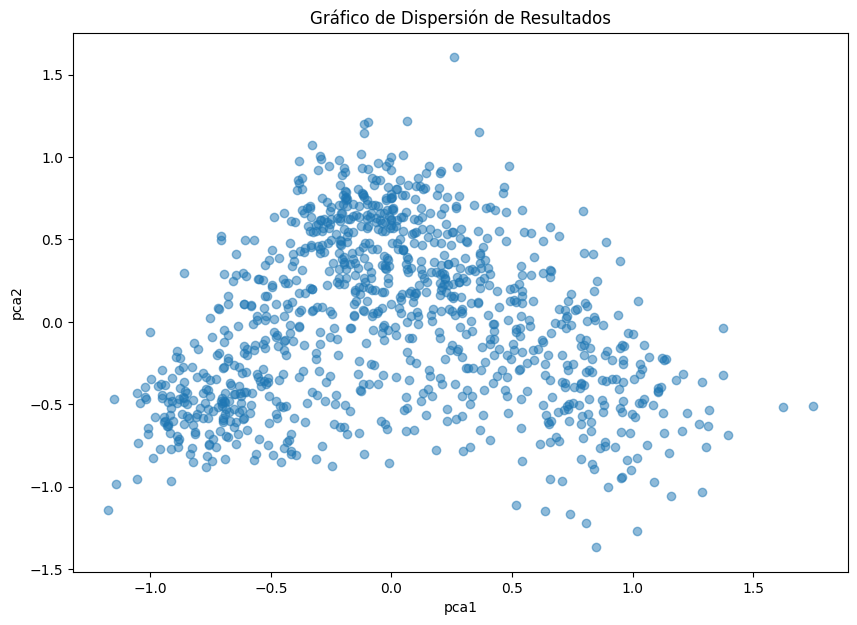

In [ ]:
# Ejemplo de uso para la función 2D
visualizar_resultados_2d(df, 'pca1', 'pca2')


## Visualizacion 3d

In [ ]:
def visualizar_resultados_3d(resultados, columna_x, columna_y, columna_z):
  pca = PCA(n_components=3)  # Para 3D
  embeddings_pca = pca.fit_transform(embeddings)

  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], embeddings_pca[:, 2], alpha=0.5)
  ax.set_xlabel('PCA1')
  ax.set_ylabel('PCA2')
  ax.set_zlabel('PCA3')
  ax.set_title('PCA of Embeddings')
  plt.show()

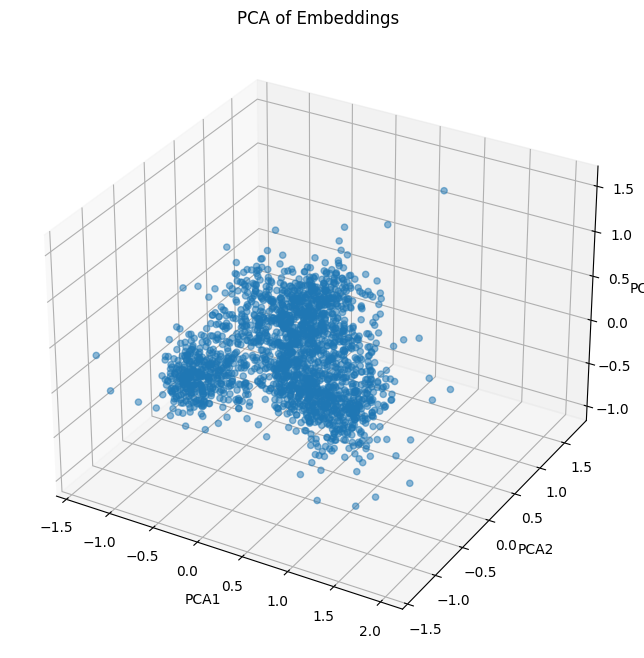

In [ ]:
visualizar_resultados_3d(df, 'pca1', 'pca2', 'pca3')